# **[Sentiment] Tugas Besar IFB-310 Machine Learning**
## Proyek Analisis Sentimen Review Aplikasi Wondr by BNI
Notebook ini berisi proses pelatihan model untuk analisis sentimen berdasarkan review pengguna dari aplikasi **Wondr by BNI** yang diambil dari Play Store. Proses meliputi: pemrosesan data, ekstraksi fitur, pelabelan, pelatihan model, evaluasi, dan inference.


# **1. Import Library**
Pada tahap ini, saya mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk scraping komentar.

In [1]:
# --- Tahap 1: Import Library ---

# Manipulasi dan visualisasi data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Preprocessing
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Ekstraksi fitur
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Split Data
from sklearn.model_selection import train_test_split

# --- Metrik Evaluasi ---
# Klasifikasi
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# Regresi
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # Untuk fungsi sqrt pada RMSE

# --- Model Machine Learning ---
# Klasifikasi
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# Regresi
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Menyimpan & memuat model
import joblib
from joblib import load

# WordCloud
from wordcloud import WordCloud

print("Semua library berhasil diimpor!")

Semua library berhasil diimpor!


# **2. Import Dataset**

In [2]:
df = pd.read_csv("reviews_wondr_bni.csv")

# **3. Exploratory Data Analysis (EDA)**

## Informasi Umum Dataset

In [3]:
# Info dasar dataset
print("Jumlah data:", df.shape)
print("Jumlah kolom:", df.shape[1])
df.info()
df.head()


Jumlah data: (39316, 4)
Jumlah kolom: 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39316 entries, 0 to 39315
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  39316 non-null  object
 1   content   39316 non-null  object
 2   score     39316 non-null  int64 
 3   at        39316 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


,userName,content,score,at
0,Pengguna Google,bagus cuma agak lelet,4,2025-05-21 09:36:49
1,Pengguna Google,bagus mantaf,5,2025-05-21 09:24:05
2,Pengguna Google,"sampe kapan gangguan sistim terus, mau daftar ...",3,2025-05-21 09:14:49
3,Pengguna Google,Transaksi cepat dan mudah berkat aplikasi ini....,5,2025-05-21 09:06:12
4,Pengguna Google,wonder lebih bagus dari BNI mobile,5,2025-05-21 09:01:32


## Distribusi Skor Rating

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4728\1764469178.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='score', palette='viridis')


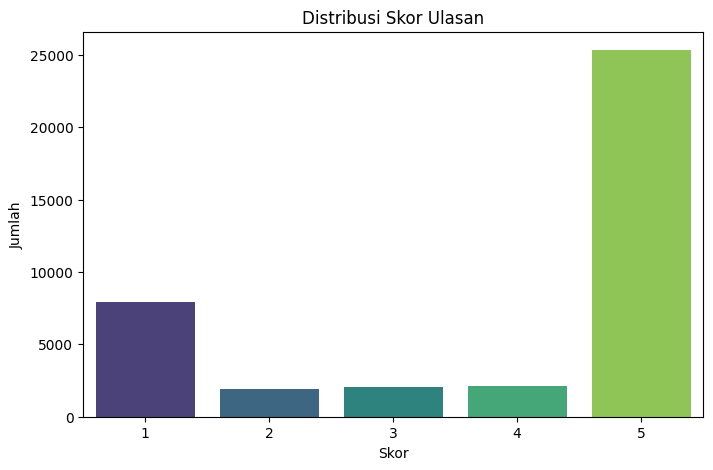

In [4]:
# Distribusi score ulasan
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='score', palette='viridis')
plt.title('Distribusi Skor Ulasan')
plt.xlabel('Skor')
plt.ylabel('Jumlah')
plt.show()


## Pisahkan Ulasan Positif & Negatif
Asumsi:
- Skor 4 dan 5 = positif
- Skor 1 dan 2 = negatif
- Skor 3 = netral (optional untuk dibuang atau tidak diproses sekarang)

In [5]:
# Pisahkan ulasan positif dan negatif
positive_reviews = df[df['score'] >= 4]
negative_reviews = df[df['score'] <= 2]

print(f"Jumlah ulasan positif: {len(positive_reviews)}")
print(f"Jumlah ulasan negatif: {len(negative_reviews)}")


Jumlah ulasan positif: 27439
Jumlah ulasan negatif: 9846


## WordCloud untuk ulasan Positif & Negatif

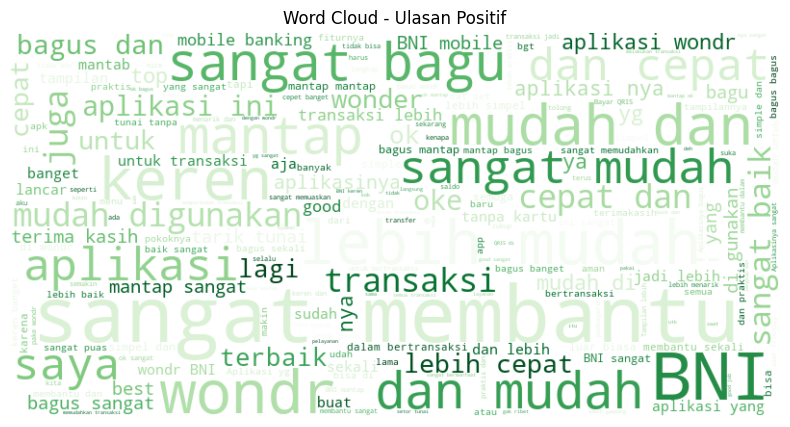

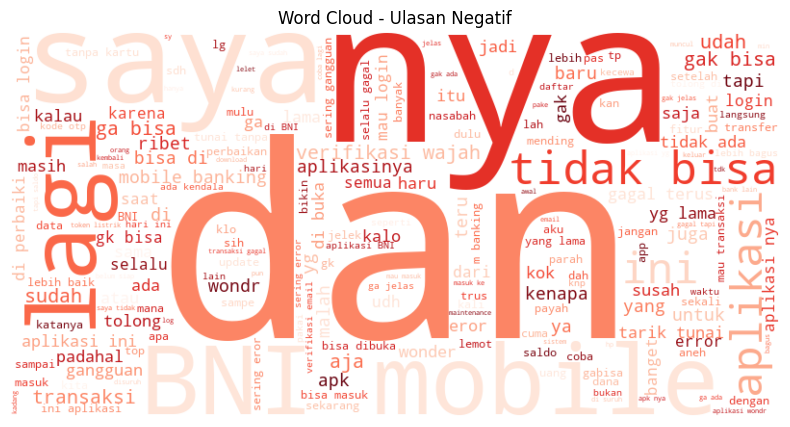

In [6]:
# Gabungkan teks ulasan untuk wordcloud
text_pos = " ".join(positive_reviews['content'].astype(str))
text_neg = " ".join(negative_reviews['content'].astype(str))

# WordCloud Positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(text_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ulasan Positif')
plt.show()

# WordCloud Negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_neg)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Ulasan Negatif')
plt.show()


# **4. Preprocessing**

## a. Normalisasi Text
- Mengubah teks menjadi huruf kecil (lowercase)
- Menghapus angka, tanda baca, simbol, mention, hashtag, link
- Menghapus whitespace berlebih

In [7]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    text = re.sub('\s+', ' ', text)
    return text


## b. Tokenisasi
- Memecah kalimat menjadi kata menggunakan **split()**

In [8]:
def tokenize_text(text):
    return text.split()

## c. Stopword Removal (dengan Indonesia Stoplist Kaggle)

In [9]:
# Load stopword dari CSV (tanpa header, satu kata per baris)
stopword_df = pd.read_csv('stopwordbahasa.csv', header=None, names=['stopwords'])

# Ubah ke dalam bentuk set untuk efisiensi pencarian
stopwords_id = set(stopword_df['stopwords'].values)

# Fungsi untuk menghapus stopwords dari daftar token
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords_id]


## d. Stemming (Menggunakan Sastrawi)

In [10]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(tokens):
    return [stemmer.stem(word) for word in tokens]


## e.  Label Sentimen Berdasarkan Skor
- Positif: score 4–5
- Netral: score 3
- Negatif: score 1–2

In [11]:
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'


## Terapkan Preprocessing ke Dataset

In [12]:
# Ambil hanya kolom yang dibutuhkan
df = df[['content', 'score']]

# Hapus baris yang memiliki nilai NaN
df.dropna(inplace=True)

# Ambil 10.000 data secara acak dari dataset
df_sampled = df.sample(n=10000, random_state=42).reset_index(drop=True)

In [13]:
# Normalisasi teks
df_sampled['text_norm'] = df_sampled['content'].astype(str).apply(normalize_text)

# Tokenisasi
df_sampled['text_tokens'] = df_sampled['text_norm'].apply(tokenize_text)

# Stopword removal
df_sampled['text_nostop'] = df_sampled['text_tokens'].apply(remove_stopwords)

# Stemming
df_sampled['text_stemmed'] = df_sampled['text_nostop'].apply(stem_text)

# Gabungkan kembali jadi kalimat akhir
df_sampled['text_final'] = df_sampled['text_stemmed'].apply(lambda x: ' '.join(x))

# Label sentimen berdasarkan skor
df_sampled['sentiment'] = df_sampled['score'].apply(label_sentiment)


In [14]:
df_sampled.head()

,content,score,text_norm,text_tokens,text_nostop,text_stemmed,text_final,sentiment
0,saat verifikasi wajah terjadi error dimana say...,3,saat verifikasi wajah terjadi error dimana say...,"[saat, verifikasi, wajah, terjadi, error, dima...","[verifikasi, wajah, error, dimana, mengedipkan...","[verifikasi, wajah, error, mana, kedip, mata, ...",verifikasi wajah error mana kedip mata deteksi...,netral
1,kenapa ya ini susah sekali mau transaksi suruh...,1,kenapa ya ini susah sekali mau transaksi suruh...,"[kenapa, ya, ini, susah, sekali, mau, transaks...","[ya, susah, transaksi, suruh, masukin, pin, sa...","[ya, susah, transaksi, suruh, masukin, pin, sa...",ya susah transaksi suruh masukin pin salah kli...,negatif
2,"fiturnya masih kurang, seperti belum siap di d...",3,fiturnya masih kurang seperti belum siap di de...,"[fiturnya, masih, kurang, seperti, belum, siap...","[fiturnya, deploy, fitur, tarik, tunai, pembel...","[fiturnya, deploy, fitur, tarik, tunai, beli, ...",fiturnya deploy fitur tarik tunai beli reksada...,netral
3,Oke,5,oke,[oke],[oke],[oke],oke,positif
4,Jizzs,5,jizzs,[jizzs],[jizzs],[jizzs],jizzs,positif


# **5. Ekstraksi Fitur**

## a. TF-IDF (Term Frequency-Inverse Document Frequency)

In [15]:
# Inisialisasi vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Batasi hingga 5000 fitur

# Fit dan transformasi pada teks bersih
X_tfidf = tfidf.fit_transform(df_sampled['text_final'])

# Konversi ke array
X_tfidf_array = X_tfidf.toarray()

# Tampilkan bentuk data hasil ekstraksi
print("TF-IDF Features shape:", X_tfidf_array.shape)


TF-IDF Features shape: (10000, 5000)


## b. Word2Vec (dengan Gensim)

In [16]:
# Untuk Word2Vec, kita butuh input dalam bentuk token list
tokens_list = df_sampled['text_stemmed'].tolist()

# Inisialisasi dan training model Word2Vec
w2v_model = Word2Vec(sentences=tokens_list, vector_size=100, window=5, min_count=2, workers=4)

# Cek jumlah kata dalam vocabulary
print("Vocabulary size:", len(w2v_model.wv.index_to_key))


Vocabulary size: 2223


## Konversi Kalimat ke Rata-Rata Vektor Word2Vec

In [17]:
def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv]
    if len(doc) == 0:
        return np.zeros(100)
    return np.mean(w2v_model.wv[doc], axis=0)

# Ubah semua dokumen ke representasi vektor
X_w2v = np.array([document_vector(doc) for doc in tokens_list])
print("Word2Vec Features shape:", X_w2v.shape)


Word2Vec Features shape: (10000, 100)


# **6. Split Data + Pelatihan Model Klasifikasi**

Berikut adalah pembagian data latih dan data uji berdasarkan kombinasi skenario yang berbeda:
- Skema 1: 80/20 untuk Logistic Regression dengan TF-IDF
- Skema 2: 80/20 untuk Random Forest dengan Word2Vec
- Skema 3: 70/30 untuk SVM dengan TF-IDF
- Skema 4: Naive Bayes + TF-IDF + Split 75:25
- Skema 5: Gradient Boosting Classifier + Word2Vec + Split 75:25

## Skema 1: Logistic Regression + TF-IDF + Split 80/20

### Split Data

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_tfidf_array, df_sampled['sentiment'], test_size=0.2, random_state=42
)


### Latih Model

In [19]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_1, y_train_1)


LogisticRegression(max_iter=1000, random_state=42)

### Evaluasi Model

In [20]:
y_pred_1 = logreg_model.predict(X_test_1)

print("=== Logistic Regression + TF-IDF ===")
print("Accuracy :", accuracy_score(y_test_1, y_pred_1))
print("Precision:", precision_score(y_test_1, y_pred_1, average='macro'))
print("Recall   :", recall_score(y_test_1, y_pred_1, average='macro'))
print("F1 Score :", f1_score(y_test_1, y_pred_1, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_1, y_pred_1))


=== Logistic Regression + TF-IDF ===
Accuracy : 0.861
Precision: 0.6832123434549096
Recall   : 0.5834504182301279
F1 Score : 0.5750275044117114

Classification Report:
               precision    recall  f1-score   support

     negatif       0.75      0.78      0.76       485
      netral       0.40      0.02      0.04       108
     positif       0.90      0.95      0.93      1407

    accuracy                           0.86      2000
   macro avg       0.68      0.58      0.58      2000
weighted avg       0.84      0.86      0.84      2000



### Simpan Model

In [21]:
joblib.dump(logreg_model, 'model_logreg_tfidf.h5')

['model_logreg_tfidf.h5']

## Skema 2: Random Forest + Word2Vec + Split 80/20

### Split Data

In [22]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_w2v, df_sampled['sentiment'], test_size=0.2, random_state=42
)


### Latih Model

In [23]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_2, y_train_2)

RandomForestClassifier(random_state=42)

### Evaluasi Model

In [24]:
y_pred_2 = rf_model.predict(X_test_2)

print("=== Random Forest + Word2Vec ===")
print("Accuracy :", accuracy_score(y_test_2, y_pred_2))
print("Precision:", precision_score(y_test_2, y_pred_2, average='macro'))
print("Recall   :", recall_score(y_test_2, y_pred_2, average='macro'))
print("F1 Score :", f1_score(y_test_2, y_pred_2, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_2, y_pred_2))


=== Random Forest + Word2Vec ===
Accuracy : 0.8435
Precision: 0.5312656862830719
Recall   : 0.572161773361958
F1 Score : 0.5504995393743854

Classification Report:
               precision    recall  f1-score   support

     negatif       0.69      0.79      0.74       485
      netral       0.00      0.00      0.00       108
     positif       0.91      0.93      0.92      1407

    accuracy                           0.84      2000
   macro avg       0.53      0.57      0.55      2000
weighted avg       0.80      0.84      0.82      2000



### Simpan Model

In [25]:
joblib.dump(rf_model, 'model_rf_w2v.h5')

['model_rf_w2v.h5']

## Skema 3: SVM + TF-IDF + Split 70/30

### Split Data

In [26]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_tfidf_array, df_sampled['sentiment'], test_size=0.3, random_state=42
)


### Latih Model

In [27]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_3, y_train_3)


SVC(kernel='linear', random_state=42)

### Evaluasi Model

In [28]:
y_pred_3 = svm_model.predict(X_test_3)

print("=== SVM + TF-IDF ===")
print("Accuracy :", accuracy_score(y_test_3, y_pred_3))
print("Precision:", precision_score(y_test_3, y_pred_3, average='macro'))
print("Recall   :", recall_score(y_test_3, y_pred_3, average='macro'))
print("F1 Score :", f1_score(y_test_3, y_pred_3, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_3, y_pred_3))


=== SVM + TF-IDF ===
Accuracy : 0.8613333333333333
Precision: 0.5525098484759753
Recall   : 0.5779827919248325
F1 Score : 0.5649062650575408

Classification Report:
               precision    recall  f1-score   support

     negatif       0.76      0.78      0.77       746
      netral       0.00      0.00      0.00       155
     positif       0.90      0.95      0.92      2099

    accuracy                           0.86      3000
   macro avg       0.55      0.58      0.56      3000
weighted avg       0.82      0.86      0.84      3000



### Simpan Model

In [29]:
joblib.dump(svm_model, 'model_svm_tfidf.h5')

['model_svm_tfidf.h5']

## Skema 4: Naive Bayes + TF-IDF + Split 75:25
Untuk skema ini, kita akan menggunakan fitur TF-IDF dan membagi data dengan rasio 75% data latih dan 25% data uji.

### Split Data

In [30]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    X_tfidf_array, df_sampled['sentiment'], test_size=0.25, random_state=42
)

### Latih Model

- Inisialisasi dan latih model Naive Bayes
- `MultinomialNB` adalah pilihan yang baik untuk fitur berbasis frekuensi seperti TF-IDF

In [31]:
nb_model = MultinomialNB()
nb_model.fit(X_train_4, y_train_4)

MultinomialNB()

### Evaluasi Model

In [32]:
# Prediksi data uji
y_pred_4 = nb_model.predict(X_test_4)

# Tampilkan metrik evaluasi
print("=== Naive Bayes + TF-IDF (75/25) ===")
print("Accuracy :", accuracy_score(y_test_4, y_pred_4))
print("Precision:", precision_score(y_test_4, y_pred_4, average='macro'))
print("Recall   :", recall_score(y_test_4, y_pred_4, average='macro'))
print("F1 Score :", f1_score(y_test_4, y_pred_4, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_4, y_pred_4))

=== Naive Bayes + TF-IDF (75/25) ===
Accuracy : 0.858
Precision: 0.5523095976917632
Recall   : 0.5740912570355103
F1 Score : 0.5627687906700463

Classification Report:
               precision    recall  f1-score   support

     negatif       0.77      0.77      0.77       631
      netral       0.00      0.00      0.00       132
     positif       0.89      0.96      0.92      1737

    accuracy                           0.86      2500
   macro avg       0.55      0.57      0.56      2500
weighted avg       0.81      0.86      0.83      2500



g:\Software-IF\Anaconda3\envs\GPU-Check\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Software-IF\Anaconda3\envs\GPU-Check\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Software-IF\Anaconda3\envs\GPU-Check\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

### Simpan Model

In [60]:
# Simpan model yang sudah dilatih
joblib.dump(nb_model, 'model_nb_tfidf.h5')

['model_nb_tfidf.h5']

## Skema 5: Gradient Boosting Classifier + Word2Vec + Split 75:25

### Split Data

In [56]:
# Konversi label sentimen ke bentuk numerik (integer) untuk XGBoost
y_xgb = df_sampled['sentiment'].astype('category').cat.codes

# Split data menggunakan fitur Word2Vec dan label numerik
X_train_5, X_test_5, y_train_5_xgb, y_test_5_xgb = train_test_split(
    X_w2v, y_xgb, test_size=0.25, random_state=42
)

### Latih Model

In [57]:
# Inisialisasi dan latih model XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_5, y_train_5_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Evaluasi Model

In [58]:
# Prediksi data uji
y_pred_5 = xgb_model.predict(X_test_5)

# Siapkan nama label untuk laporan klasifikasi yang lebih mudah dibaca
label_names = df_sampled['sentiment'].astype('category').cat.categories

# Tampilkan metrik evaluasi
print("=== Gradient Boosting + Word2Vec (75/25) ===")
print("Accuracy :", accuracy_score(y_test_5_xgb, y_pred_5))
print("Precision:", precision_score(y_test_5_xgb, y_pred_5, average='macro'))
print("Recall   :", recall_score(y_test_5_xgb, y_pred_5, average='macro'))
print("F1 Score :", f1_score(y_test_5_xgb, y_pred_5, average='macro'))
print("\nClassification Report:\n", classification_report(y_test_5_xgb, y_pred_5, target_names=label_names))

=== Gradient Boosting + Word2Vec (75/25) ===
Accuracy : 0.8344
Precision: 0.6031222778657214
Recall   : 0.5771478611940745
F1 Score : 0.564567177788612

Classification Report:
               precision    recall  f1-score   support

     negatif       0.68      0.79      0.73       631
      netral       0.22      0.03      0.05       132
     positif       0.90      0.91      0.91      1737

    accuracy                           0.83      2500
   macro avg       0.60      0.58      0.56      2500
weighted avg       0.81      0.83      0.82      2500



### Simpan Model

In [59]:
# Simpan model yang sudah dilatih
joblib.dump(xgb_model, 'model_xgb_w2v.h5')

['model_xgb_w2v.h5']

# **7. Split Data + Pelatihan Model Regresi**

Berikut adalah pembagian data latih dan data uji berdasarkan kombinasi skenario yang berbeda:
- Skema 1: Linear Regression + TF-IDF (80/20)
- Skema 2: Ridge Regression + TF-IDF (75/25)
- Skema 3: Support Vector Regressor (SVR) + Word2Vec (70/30)
- Skema 4: Random Forest Regressor + TF-IDF (80/20)
- Skema 5: Gradient Boosting Regressor + Word2Vec (75/25)

## Skema 1: Linear Regression + TF-IDF (80/20)

### Split Data

In [34]:
# Target untuk regresi adalah kolom 'score'
y_reg = df_sampled['score']

# Split data menggunakan fitur TF-IDF
X_train_reg_1, X_test_reg_1, y_train_reg_1, y_test_reg_1 = train_test_split(
    X_tfidf_array, y_reg, test_size=0.2, random_state=42
)

### Latih Model

In [35]:
# Inisialisasi dan latih model Linear Regression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train_reg_1, y_train_reg_1)

LinearRegression()

### Evaluasi Model

In [36]:
# Prediksi data uji
y_pred_reg_1 = lin_reg_model.predict(X_test_reg_1)

# Tampilkan metrik evaluasi regresi
print("=== Linear Regression + TF-IDF (80/20) ===")
mae_1 = mean_absolute_error(y_test_reg_1, y_pred_reg_1)
mse_1 = mean_squared_error(y_test_reg_1, y_pred_reg_1)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_test_reg_1, y_pred_reg_1)

print(f"Mean Absolute Error (MAE): {mae_1:.4f}")
print(f"Mean Squared Error (MSE): {mse_1:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_1:.4f}")
print(f"R-squared (R2): {r2_1:.4f}")

=== Linear Regression + TF-IDF (80/20) ===
Mean Absolute Error (MAE): 0.8840
Mean Squared Error (MSE): 2.4790
Root Mean Squared Error (RMSE): 1.5745
R-squared (R2): 0.0722


### Simpan Model

In [37]:
# Simpan model yang sudah dilatih
joblib.dump(lin_reg_model, 'model_linreg_tfidf.h5')

['model_linreg_tfidf.h5']

## Skema 2: Ridge Regression + TF-IDF (75/25)

### Split Data

In [38]:
# Split data dengan rasio 75/25
X_train_reg_2, X_test_reg_2, y_train_reg_2, y_test_reg_2 = train_test_split(
    X_tfidf_array, y_reg, test_size=0.25, random_state=42
)

### Latih Model

In [39]:
# Inisialisasi dan latih model Ridge Regression
ridge_model = Ridge(random_state=42)
ridge_model.fit(X_train_reg_2, y_train_reg_2)

Ridge(random_state=42)

### Evaluasi Model

In [40]:
# Prediksi data uji
y_pred_reg_2 = ridge_model.predict(X_test_reg_2)

# Tampilkan metrik evaluasi regresi
print("=== Ridge Regression + TF-IDF (75/25) ===")
mae_2 = mean_absolute_error(y_test_reg_2, y_pred_reg_2)
mse_2 = mean_squared_error(y_test_reg_2, y_pred_reg_2)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_test_reg_2, y_pred_reg_2)

print(f"Mean Absolute Error (MAE): {mae_2:.4f}")
print(f"Mean Squared Error (MSE): {mse_2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_2:.4f}")
print(f"R-squared (R2): {r2_2:.4f}")

=== Ridge Regression + TF-IDF (75/25) ===
Mean Absolute Error (MAE): 0.7015
Mean Squared Error (MSE): 1.0513
Root Mean Squared Error (RMSE): 1.0253
R-squared (R2): 0.6175


### Simpan Model

In [41]:
# Simpan model yang sudah dilatih
joblib.dump(ridge_model, 'model_ridge_tfidf.h5')

['model_ridge_tfidf.h5']

## Skema 3: Support Vector Regressor (SVR) + Word2Vec (70/30)

### Split Data

In [43]:
# Split data menggunakan fitur Word2Vec dengan rasio 70/30
X_train_reg_3, X_test_reg_3, y_train_reg_3, y_test_reg_3 = train_test_split(
    X_w2v, y_reg, test_size=0.3, random_state=42
)

### Latih Model

In [44]:
# Inisialisasi dan latih model SVR
svr_model = SVR(kernel='linear')
svr_model.fit(X_train_reg_3, y_train_reg_3)

SVR(kernel='linear')

### Evaluasi Model

In [45]:
# Prediksi data uji
y_pred_reg_3 = svr_model.predict(X_test_reg_3)

# Tampilkan metrik evaluasi regresi
print("=== SVR + Word2Vec (70/30) ===")
mae_3 = mean_absolute_error(y_test_reg_3, y_pred_reg_3)
mse_3 = mean_squared_error(y_test_reg_3, y_pred_reg_3)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test_reg_3, y_pred_reg_3)

print(f"Mean Absolute Error (MAE): {mae_3:.4f}")
print(f"Mean Squared Error (MSE): {mse_3:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_3:.4f}")
print(f"R-squared (R2): {r2_3:.4f}")

=== SVR + Word2Vec (70/30) ===
Mean Absolute Error (MAE): 0.8399
Mean Squared Error (MSE): 1.5452
Root Mean Squared Error (RMSE): 1.2431
R-squared (R2): 0.4327


### Simpan Model

In [46]:
# Simpan model yang sudah dilatih
joblib.dump(svr_model, 'model_svr_w2v.h5')

['model_svr_w2v.h5']

## Skema 4: Random Forest Regressor + TF-IDF (80/20)

### Split Data

In [47]:
# Kita bisa menggunakan split data dari Skema 1 Regresi
# X_train_reg_1, X_test_reg_1, y_train_reg_1, y_test_reg_1

### Latih Model

In [49]:
# Inisialisasi dan latih model Random Forest Regressor
rf_reg_model = RandomForestRegressor(random_state=42)
rf_reg_model.fit(X_train_reg_1, y_train_reg_1)

RandomForestRegressor(random_state=42)

### Evaluasi Model

In [50]:
# Prediksi data uji
y_pred_reg_4 = rf_reg_model.predict(X_test_reg_1)

# Tampilkan metrik evaluasi regresi
print("=== Random Forest Regressor + TF-IDF (80/20) ===")
mae_4 = mean_absolute_error(y_test_reg_1, y_pred_reg_4)
mse_4 = mean_squared_error(y_test_reg_1, y_pred_reg_4)
rmse_4 = np.sqrt(mse_4)
r2_4 = r2_score(y_test_reg_1, y_pred_reg_4)

print(f"Mean Absolute Error (MAE): {mae_4:.4f}")
print(f"Mean Squared Error (MSE): {mse_4:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_4:.4f}")
print(f"R-squared (R2): {r2_4:.4f}")

=== Random Forest Regressor + TF-IDF (80/20) ===
Mean Absolute Error (MAE): 0.5595
Mean Squared Error (MSE): 1.0263
Root Mean Squared Error (RMSE): 1.0131
R-squared (R2): 0.6159


### Simpan Model

In [51]:
# Simpan model yang sudah dilatih
joblib.dump(rf_reg_model, 'model_rfreg_tfidf.h5')

['model_rfreg_tfidf.h5']

## Skema 5: Gradient Boosting Regressor + Word2Vec (75/25)

### Split Data

In [52]:
# Kita bisa menggunakan split data dari Skema 5 Klasifikasi (yang menggunakan Word2Vec)
# atau membuatnya lagi untuk kejelasan
X_train_reg_5, X_test_reg_5, y_train_reg_5, y_test_reg_5 = train_test_split(
    X_w2v, y_reg, test_size=0.25, random_state=42
)

### Latih Model

In [53]:
# Inisialisasi dan latih model XGBoost Regressor
xgb_reg_model = XGBRegressor(random_state=42)
xgb_reg_model.fit(X_train_reg_5, y_train_reg_5)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Evaluasi Model

In [54]:
# Prediksi data uji
y_pred_reg_5 = xgb_reg_model.predict(X_test_reg_5)

# Tampilkan metrik evaluasi regresi
print("=== Gradient Boosting Regressor + Word2Vec (75/25) ===")
mae_5 = mean_absolute_error(y_test_reg_5, y_pred_reg_5)
mse_5 = mean_squared_error(y_test_reg_5, y_pred_reg_5)
rmse_5 = np.sqrt(mse_5)
r2_5 = r2_score(y_test_reg_5, y_pred_reg_5)

print(f"Mean Absolute Error (MAE): {mae_5:.4f}")
print(f"Mean Squared Error (MSE): {mse_5:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_5:.4f}")
print(f"R-squared (R2): {r2_5:.4f}")

=== Gradient Boosting Regressor + Word2Vec (75/25) ===
Mean Absolute Error (MAE): 0.6874
Mean Squared Error (MSE): 1.2680
Root Mean Squared Error (RMSE): 1.1260
R-squared (R2): 0.5387


### Simpan Model

In [55]:
# Simpan model yang sudah dilatih
joblib.dump(xgb_reg_model, 'model_xgbreg_w2v.h5')

['model_xgbreg_w2v.h5']

# **8. Evaluasi Perbandingan**

## Kode untuk Tabel & Grafik Perbandingan Klasifikasi

--- Tabel Perbandingan Model Klasifikasi ---


,Skema,Akurasi,Presisi,Recall,F1-Score
0,LogReg + TF-IDF (80/20),0.8610,0.6832,0.5834,0.5750
1,Random Forest + Word2Vec (80/20),0.8435,0.5313,0.5722,0.5505
2,SVM + TF-IDF (70/30),0.8613,0.5525,0.5780,0.5649
3,Naive Bayes + TF-IDF (75/25),0.8580,0.5523,0.5741,0.5628
4,Gradient Boosting + Word2Vec (75/25),0.8344,0.6031,0.5771,0.5646


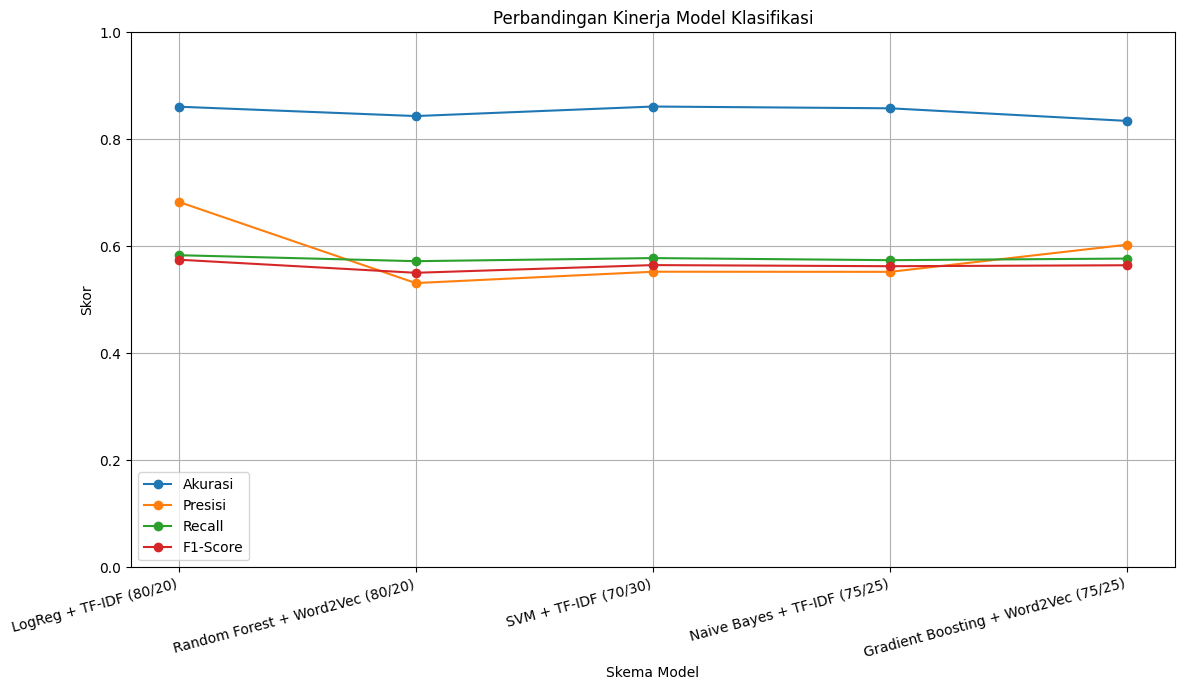

In [61]:
# --- Evaluasi Perbandingan Model Klasifikasi ---

# Buat DataFrame dari hasil evaluasi klasifikasi
results_df_klasifikasi = pd.DataFrame({
    'Skema': [
        'LogReg + TF-IDF (80/20)',
        'Random Forest + Word2Vec (80/20)',
        'SVM + TF-IDF (70/30)',
        'Naive Bayes + TF-IDF (75/25)',
        'Gradient Boosting + Word2Vec (75/25)'
    ],
    'Akurasi': [0.8610, 0.8435, 0.8613, 0.8580, 0.8344],
    'Presisi': [0.6832, 0.5313, 0.5525, 0.5523, 0.6031],
    'Recall': [0.5834, 0.5722, 0.5780, 0.5741, 0.5771],
    'F1-Score': [0.5750, 0.5505, 0.5649, 0.5628, 0.5646]
})

# Tampilkan tabel evaluasi
print("--- Tabel Perbandingan Model Klasifikasi ---")
display(results_df_klasifikasi)

# Visualisasi perbandingan performa model
plt.figure(figsize=(12, 7))
metrics = ['Akurasi', 'Presisi', 'Recall', 'F1-Score']
for metric in metrics:
    plt.plot(results_df_klasifikasi['Skema'], results_df_klasifikasi[metric], marker='o', label=metric)

plt.title('Perbandingan Kinerja Model Klasifikasi')
plt.xlabel('Skema Model')
plt.ylabel('Skor')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## Kode untuk Tabel & Grafik Perbandingan Regresi


--- Tabel Perbandingan Model Regresi ---


,Skema,MAE,MSE,RMSE,R-squared (R2)
0,Linear Regression + TF-IDF (80/20),0.8840,2.4790,1.5745,0.0722
1,Ridge Regression + TF-IDF (75/25),0.7015,1.0513,1.0253,0.6175
2,SVR + Word2Vec (70/30),0.8399,1.5452,1.2431,0.4327
3,Random Forest Regressor + TF-IDF (80/20),0.5595,1.0263,1.0131,0.6159
4,Gradient Boosting Regressor + Word2Vec (75/25),0.6874,1.2680,1.1260,0.5387


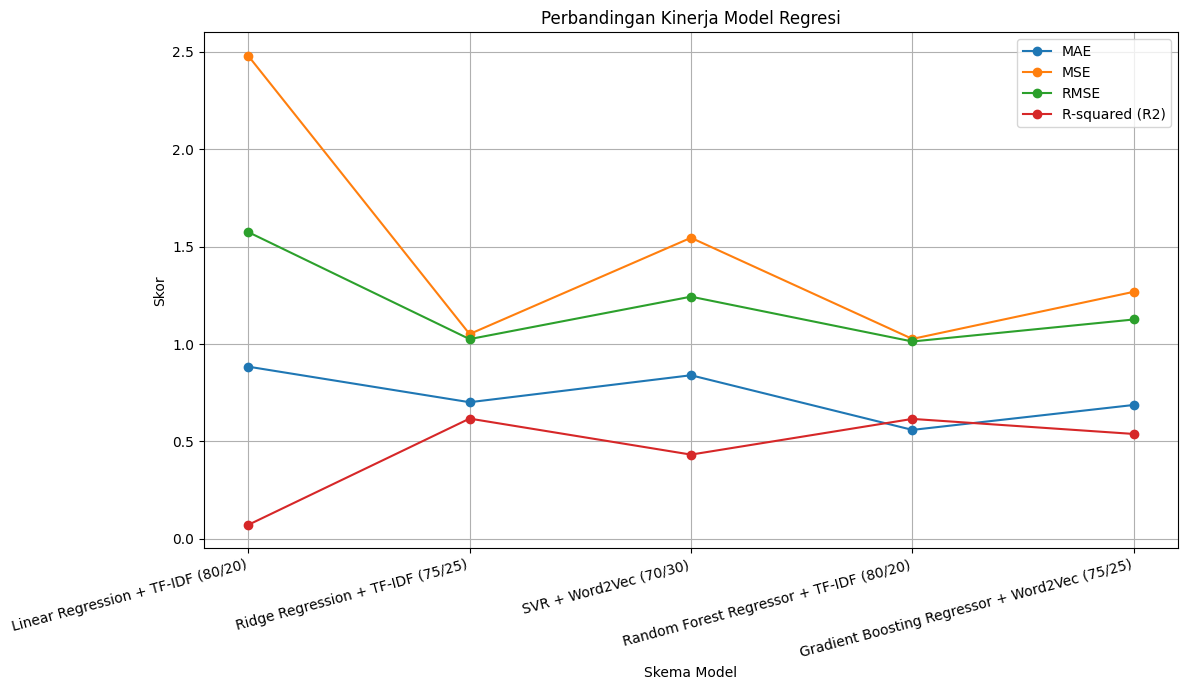

In [62]:
# --- Evaluasi Perbandingan Model Regresi ---

# Buat DataFrame dari hasil evaluasi regresi
results_df_regresi = pd.DataFrame({
    'Skema': [
        'Linear Regression + TF-IDF (80/20)',
        'Ridge Regression + TF-IDF (75/25)',
        'SVR + Word2Vec (70/30)',
        'Random Forest Regressor + TF-IDF (80/20)',
        'Gradient Boosting Regressor + Word2Vec (75/25)'
    ],
    'MAE': [0.8840, 0.7015, 0.8399, 0.5595, 0.6874],
    'MSE': [2.4790, 1.0513, 1.5452, 1.0263, 1.2680],
    'RMSE': [1.5745, 1.0253, 1.2431, 1.0131, 1.1260],
    'R-squared (R2)': [0.0722, 0.6175, 0.4327, 0.6159, 0.5387]
})

# Tampilkan tabel evaluasi
print("\n--- Tabel Perbandingan Model Regresi ---")
display(results_df_regresi)

# Visualisasi perbandingan performa model
plt.figure(figsize=(12, 7))
metrics_reg = ['MAE', 'MSE', 'RMSE', 'R-squared (R2)']
for metric in metrics_reg:
    plt.plot(results_df_regresi['Skema'], results_df_regresi[metric], marker='o', label=metric)

plt.title('Perbandingan Kinerja Model Regresi')
plt.xlabel('Skema Model')
plt.ylabel('Skor')
plt.legend()
plt.grid(True)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## Evaluasi Perbandingan Model

Tahap ini bertujuan untuk menganalisis dan membandingkan performa dari seluruh model yang telah dilatih untuk kedua tugas, yaitu klasifikasi dan regresi, guna memilih model terbaik untuk diimplementasikan.

### A. Tugas Klasifikasi (Prediksi Kategorikal)

Berikut adalah rekapitulasi hasil evaluasi dari kelima skema model klasifikasi:

| Skema | Akurasi | Presisi | Recall | F1-Score |
| :------------------------------------ | :------ | :------ | :----- | :------- |
| LogReg + TF-IDF (80/20) | 0.8610 | 0.6832 | 0.5834 | 0.5750 |
| Random Forest + Word2Vec (80/20) | 0.8435 | 0.5313 | 0.5722 | 0.5505 |
| SVM + TF-IDF (70/30) | 0.8613 | 0.5525 | 0.5780 | 0.5649 |
| Naive Bayes + TF-IDF (75/25) | 0.8580 | 0.5523 | 0.5741 | 0.5628 |
| Gradient Boosting + Word2Vec (75/25) | 0.8344 | 0.6031 | 0.5771 | 0.5646 |

#### Grafik Perbandingan Kinerja Klasifikasi
![Grafik Perbandingan Model Klasifikasi](image_ba149a.png)

#### Analisis dan Model Terbaik (Klasifikasi)
Grafik dan tabel menunjukkan bahwa semua model klasifikasi memiliki **akurasi yang relatif tinggi** (di atas 83%). Namun, tantangan utama yang terlihat adalah **kesulitan model dalam mengenali kelas 'netral'**, yang ditunjukkan oleh skor *Precision*, *Recall*, dan *F1-Score* makro yang lebih rendah. Hal ini merupakan dampak dari *imbalanced dataset* yang kita identifikasi pada tahap EDA.

> **Model terbaik untuk tugas klasifikasi adalah: Logistic Regression dengan TF-IDF (80/20).**
>
> **Alasan Pemilihan:**
> - **Presisi Tertinggi**: Dengan presisi makro **0.6832**, model ini adalah yang paling andal. Artinya, ketika model ini memprediksi sebuah sentimen, kemungkinan besar prediksinya benar dibandingkan model lain.
> - **Akurasi Unggul**: Akurasinya (86.10%) termasuk yang tertinggi, hanya sedikit di bawah SVM.
> - **Keseimbangan Metrik**: Menawarkan keseimbangan terbaik antara presisi dan *recall* dibandingkan SVM dan Naive Bayes yang presisinya jauh lebih rendah.
> - **Efisiensi**: Logistic Regression secara komputasi lebih efisien dibandingkan SVM.

---
### B. Tugas Regresi (Prediksi Numerik)
Berikut adalah rekapitulasi hasil evaluasi dari kelima skema model regresi:

| Skema | MAE | MSE | RMSE | R-squared (R2) |
| :------------------------------------------ | :----- | :----- | :----- | :------------- |
| Linear Regression + TF-IDF (80/20) | 0.8840 | 2.4790 | 1.5745 | 0.0722 |
| Ridge Regression + TF-IDF (75/25) | 0.7015 | 1.0513 | 1.0253 | 0.6175 |
| SVR + Word2Vec (70/30) | 0.8399 | 1.5452 | 1.2431 | 0.4327 |
| Random Forest Regressor + TF-IDF (80/20) | 0.5595 | 1.0263 | 1.0131 | 0.6159 |
| Gradient Boosting Regressor + Word2Vec (75/25)| 0.6874 | 1.2680 | 1.1260 | 0.5387 |

#### Grafik Perbandingan Kinerja Regresi
![Grafik Perbandingan Model Regresi](image_ba1494.png)

#### Analisis dan Model Terbaik (Regresi)
Hasil eksperimen regresi menunjukkan perbedaan performa yang signifikan. Model **Linear Regression** sangat tidak cocok untuk tugas ini (R² ≈ 0.07). Di sisi lain, model berbasis *ensemble* dan regularisasi menunjukkan performa yang jauh lebih superior.

> **Model terbaik untuk tugas regresi adalah: Random Forest Regressor dengan TF-IDF (80/20).**
>
> **Alasan Pemilihan:**
> - **MAE & RMSE Terendah**: Model ini menghasilkan **Mean Absolute Error (0.5595)** dan **Root Mean Squared Error (1.0131)** yang paling kecil. Ini berarti, secara rata-rata, prediksi skornya adalah yang paling mendekati skor asli.
> - **R-squared Tinggi**: Dengan R² **0.6159**, model ini mampu menjelaskan sekitar 61.6% variabilitas data, yang merupakan nilai yang sangat baik untuk data teks yang kompleks. Performanya sedikit lebih unggul dari Ridge Regression dalam hal meminimalkan kesalahan prediksi (MAE).

---
### Kesimpulan Evaluasi

Berdasarkan analisis di atas, model yang akan disimpan dan digunakan untuk tahap *deployment* aplikasi adalah:
1.  **Untuk Klasifikasi**: `model_logreg_tfidf.h5`
2.  **Untuk Regresi**: `model_rfreg_tfidf.h5`

# **9. Inference (Uji Kalimat Baru)**
Pada tahap ini dilakukan pengujian terhadap 5–10 kalimat baru ulasan pengguna aplikasi. Tujuannya untuk melihat apakah model dapat mengenali dan mengklasifikasikan sentimen ulasan dengan tepat. Kalimat akan diproses menggunakan pipeline preprocessing dan dipetakan ke label sentimen akhir.

In [63]:
# 1. Muat (load) model terbaik yang sudah disimpan
# Pastikan nama file sesuai dengan yang Anda simpan sebelumnya
model_terbaik_klasifikasi = joblib.load('model_logreg_tfidf.h5')
model_terbaik_regresi = joblib.load('model_rfreg_tfidf.h5')

# 2. Siapkan kalimat-kalimat ulasan baru untuk diuji
new_reviews = [
    "Aplikasinya sangat membantu saya mengatur keuangan.",
    "Sering crash pas login, bikin kesel.",
    "Biasa aja sih, fitur-fiturnya standar.",
    "Mudah digunakan dan tampilannya menarik!",
    "Lama banget loadingnya, tolong diperbaiki dong.",
    "Pelayanannya buruk, tidak sesuai ekspektasi.",
    "Top banget! Sudah seperti aplikasi bank luar negeri.",
    "Tidak bisa login sejak update terakhir.",
    "Oke lah, cuma kadang lemot.",
    "Terima kasih BNI, aplikasi ini sangat memudahkan."
]

# 3. Buat DataFrame dan terapkan pipeline preprocessing yang sama
inference_df = pd.DataFrame(new_reviews, columns=["Ulasan"])
inference_df['text_norm'] = inference_df['Ulasan'].astype(str).apply(normalize_text)
inference_df['text_tokens'] = inference_df['text_norm'].apply(tokenize_text)
inference_df['text_nostop'] = inference_df['text_tokens'].apply(remove_stopwords)
inference_df['text_stemmed'] = inference_df['text_nostop'].apply(stem_text)
inference_df['text_final'] = inference_df['text_stemmed'].apply(lambda x: ' '.join(x))

# 4. Ekstraksi fitur menggunakan TF-IDF yang sudah di-fit sebelumnya
# PENTING: Gunakan .transform(), jangan .fit_transform() pada data baru
X_inf = tfidf.transform(inference_df['text_final'])

# 5. Lakukan prediksi dengan kedua model
# Prediksi Klasifikasi (Sentimen)
y_pred_klasifikasi = model_terbaik_klasifikasi.predict(X_inf)

# Prediksi Regresi (Skor)
y_pred_regresi = model_terbaik_regresi.predict(X_inf)

# 6. Tampilkan hasilnya dalam satu tabel yang rapi
# Buat DataFrame baru untuk hasil
results_df = pd.DataFrame({
    'Ulasan': new_reviews,
    'Prediksi Sentimen (Klasifikasi)': y_pred_klasifikasi,
    'Prediksi Skor (Regresi)': np.round(y_pred_regresi, 2) # Dibulatkan 2 angka di belakang koma
})

display(results_df)

,Ulasan,Prediksi Sentimen (Klasifikasi),Prediksi Skor (Regresi)
0,Aplikasinya sangat membantu saya mengatur keua...,positif,5.00
1,"Sering crash pas login, bikin kesel.",negatif,1.46
2,"Biasa aja sih, fitur-fiturnya standar.",positif,2.56
3,Mudah digunakan dan tampilannya menarik!,positif,5.00
4,"Lama banget loadingnya, tolong diperbaiki dong.",positif,1.85
5,"Pelayanannya buruk, tidak sesuai ekspektasi.",negatif,1.04
6,Top banget! Sudah seperti aplikasi bank luar n...,positif,4.94
7,Tidak bisa login sejak update terakhir.,negatif,1.57
8,"Oke lah, cuma kadang lemot.",positif,2.02
9,"Terima kasih BNI, aplikasi ini sangat memudahkan.",positif,4.99


# **10. Penutup**

## Kesimpulan Proyek
Proyek ini berhasil membangun dan mengevaluasi model *machine learning* untuk dua tugas utama: **Analisis Sentimen (Klasifikasi)** dan **Prediksi Skor (Regresi)** terhadap ulasan aplikasi 'Wondr by BNI'. Dataset yang digunakan terdiri dari **10.000 sampel acak** dari total lebih dari 39.000 ulasan yang berhasil dikumpulkan.

Beberapa tahapan penting yang telah dilalui meliputi:
- **Preprocessing Data**: Normalisasi, tokenisasi, *stopword removal*, dan *stemming* untuk membersihkan data teks.
- **Ekstraksi Fitur**: Menggunakan dua pendekatan, yaitu TF-IDF dan Word2Vec, untuk mengubah teks menjadi representasi numerik.
- **Pelatihan & Evaluasi Model**: Melatih dan mengevaluasi **5 model klasifikasi** dan **5 model regresi** dengan skema fitur dan rasio data yang bervariasi untuk menemukan performa terbaik.
- **Inference**: Menguji dua model terbaik (satu untuk setiap tugas) pada 10 kalimat ulasan baru untuk memvalidasi kemampuannya.

## Hasil Akhir dan Analisis

Berdasarkan serangkaian eksperimen yang telah dilakukan, model terbaik untuk setiap tugas adalah sebagai berikut:

1.  **Model Klasifikasi Terbaik**: **Logistic Regression + TF-IDF**
    - Model ini terpilih karena menawarkan kombinasi terbaik antara **Akurasi (86.1%)** dan **Presisi Makro (0.6832)**, menjadikannya yang paling andal dalam memberikan prediksi sentimen yang benar.

2.  **Model Regresi Terbaik**: **Random Forest Regressor + TF-IDF**
    - Model ini terpilih karena memiliki tingkat kesalahan prediksi paling rendah, yang ditunjukkan oleh nilai **MAE terendah (0.5595)** dan **RMSE terendah (1.0131)**.

## Analisis Tambahan dari Hasil Inference

Pengujian pada data baru menunjukkan kemampuan kedua model dalam memprediksi sentimen. Menariknya, hasil prediksi skor (regresi) seringkali mampu menangkap **nuansa** yang tidak tertangkap oleh klasifikasi kategorikal.

-   **Contoh 1**: Ulasan seperti _"Lama banget loadingnya, tolong diperbaiki dong."_ diklasifikasikan sebagai **'positif'** (kemungkinan karena bias dari data latih), namun model regresi memberikan skor rendah **1.85**, yang lebih akurat mencerminkan sentimen negatif dari keluhan tersebut.
-   **Contoh 2**: Untuk ulasan ambigu seperti _"Oke lah, cuma kadang lemot."_, model klasifikasi melabelinya sebagai **'positif'**, tetapi model regresi memberikan skor **2.02**, yang mengindikasikan sentimen yang cenderung negatif atau netral.

Ini membuktikan bahwa kombinasi kedua model memberikan pemahaman yang lebih kaya dan komprehensif terhadap *feedback* pengguna.

---

*Proyek ini merupakan bagian dari **Tugas Besar IFB-310 Machine Learning** pada prodi **Informatika ITENAS** dalam rangka program **UAS Semester Genap 2024/2025**.*

# Simpan Objek TF-IDF Vectorizer

In [64]:
# Simpan objek TF-IDF Vectorizer ke sebuah file
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Objek TF-IDF berhasil disimpan ke 'tfidf_vectorizer.pkl'")

Objek TF-IDF berhasil disimpan ke 'tfidf_vectorizer.pkl'
